# BERT Embeddings with TensorFlow 2.0

- See BERT on paper: https://arxiv.org/pdf/1810.04805.pdf
- See BERT on GitHub: https://github.com/google-research/bert
- See BERT on TensorHub: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1
- See 'old' use of BERT for comparison: https://colab.research.google.com/github/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb

In [2]:
!pip install tf-nightly

     |████████████████████████████████| 345.4MB 47kB/s 
     |████████████████████████████████| 8.9MB 3.2MB/s 
     |████████████████████████████████| 460kB 40.8MB/s 


In [3]:
import tensorflow as tf

In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17864892153743418742]

In [5]:
import numpy as np
import tensorflow as tf
import os

import distutils
if distutils.version.LooseVersion(tf.__version__) < '2.0':
    raise Exception('This notebook is compatible with TensorFlow 2.0 or higher.')



# TPU Testing

Testing that either tensorflow geting access to TPU or not.

In [6]:
tf.keras.backend.clear_session()

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Initializing the TPU system: grpc://10.116.206.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.116.206.50:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU')]


# Installing Packages

In [7]:
# Instaling Packages
!pip install tensorflow_hub
!pip install bert-for-tf2
!pip install sentencepiece
!pip install tf-hub-nightly

     |████████████████████████████████| 40kB 1.9MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.5-cp36-none-any.whl size=30315 sha256=b8e550e2c60c16e9adcc731c961bc187b3df1e0669a63c8ec53889ec1e9f3831
  Stored in directory: /root/.cache/pip/wheels/2e/70/a2/be357037dd2cbdcaeb0add1fdf083be6a600ca65ee1f68751c
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7302 sha256=9f81780cf4c6c953e2d83e80c164a761965334409c515ea3e40d9c7a0637451d
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19473 sha256=0a993f44d3306e73201cfed69201db62ab3943540ec5a35e817585ac8bb63649
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow
     |████████████████████████████████| 1.1MB 3.4MB/s 
     |█████████████████████████████

In [8]:
import tensorflow_hub as hub
print("TF version: ", tf.__version__)
print("Hub version: ", hub.__version__)

TF version:  2.4.0-dev20200822
Hub version:  0.10.0.dev


In [9]:
hub.__version__

'0.10.0.dev'

## Importing Modules

In [10]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

from tensorflow import keras

import bert # Importing BERT
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

In [11]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Configurations

In [12]:
# COnfiguration 
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

## Downloading Data Set


In [71]:
!gdown --id 1OlcvGWReJMuyYQuOZm149vHWwPtlboR6 --output train.csv
!gdown --id 1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w --output valid.csv
!gdown --id 1ep9H6-HvhB4utJRLVcLzieWNUSG3P_uF --output test.csv

Downloading...
From: https://drive.google.com/uc?id=1OlcvGWReJMuyYQuOZm149vHWwPtlboR6
To: /content/train.csv
100% 799k/799k [00:00<00:00, 50.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w
To: /content/valid.csv
100% 43.3k/43.3k [00:00<00:00, 37.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ep9H6-HvhB4utJRLVcLzieWNUSG3P_uF
To: /content/test.csv
100% 43.1k/43.1k [00:00<00:00, 34.0MB/s]


In [14]:
# Reading Data from csvfiles
train = pd.read_csv("train.csv")
valid = pd.read_csv("valid.csv")
test = pd.read_csv("test.csv")

In [15]:
# merging train and validation data
train = train.append(valid).reset_index(drop=True)

In [16]:
train.head()

,text,intent
0,listen to westbam alumb allergic on google music,PlayMusic
1,add step to me to the 50 clásicos playlist,AddToPlaylist
2,i give this current textbook a rating value of...,RateBook
3,play the song little robin redbreast,PlayMusic
4,please add iris dement to my playlist this is ...,AddToPlaylist


In [17]:
train.shape

(13784, 2)

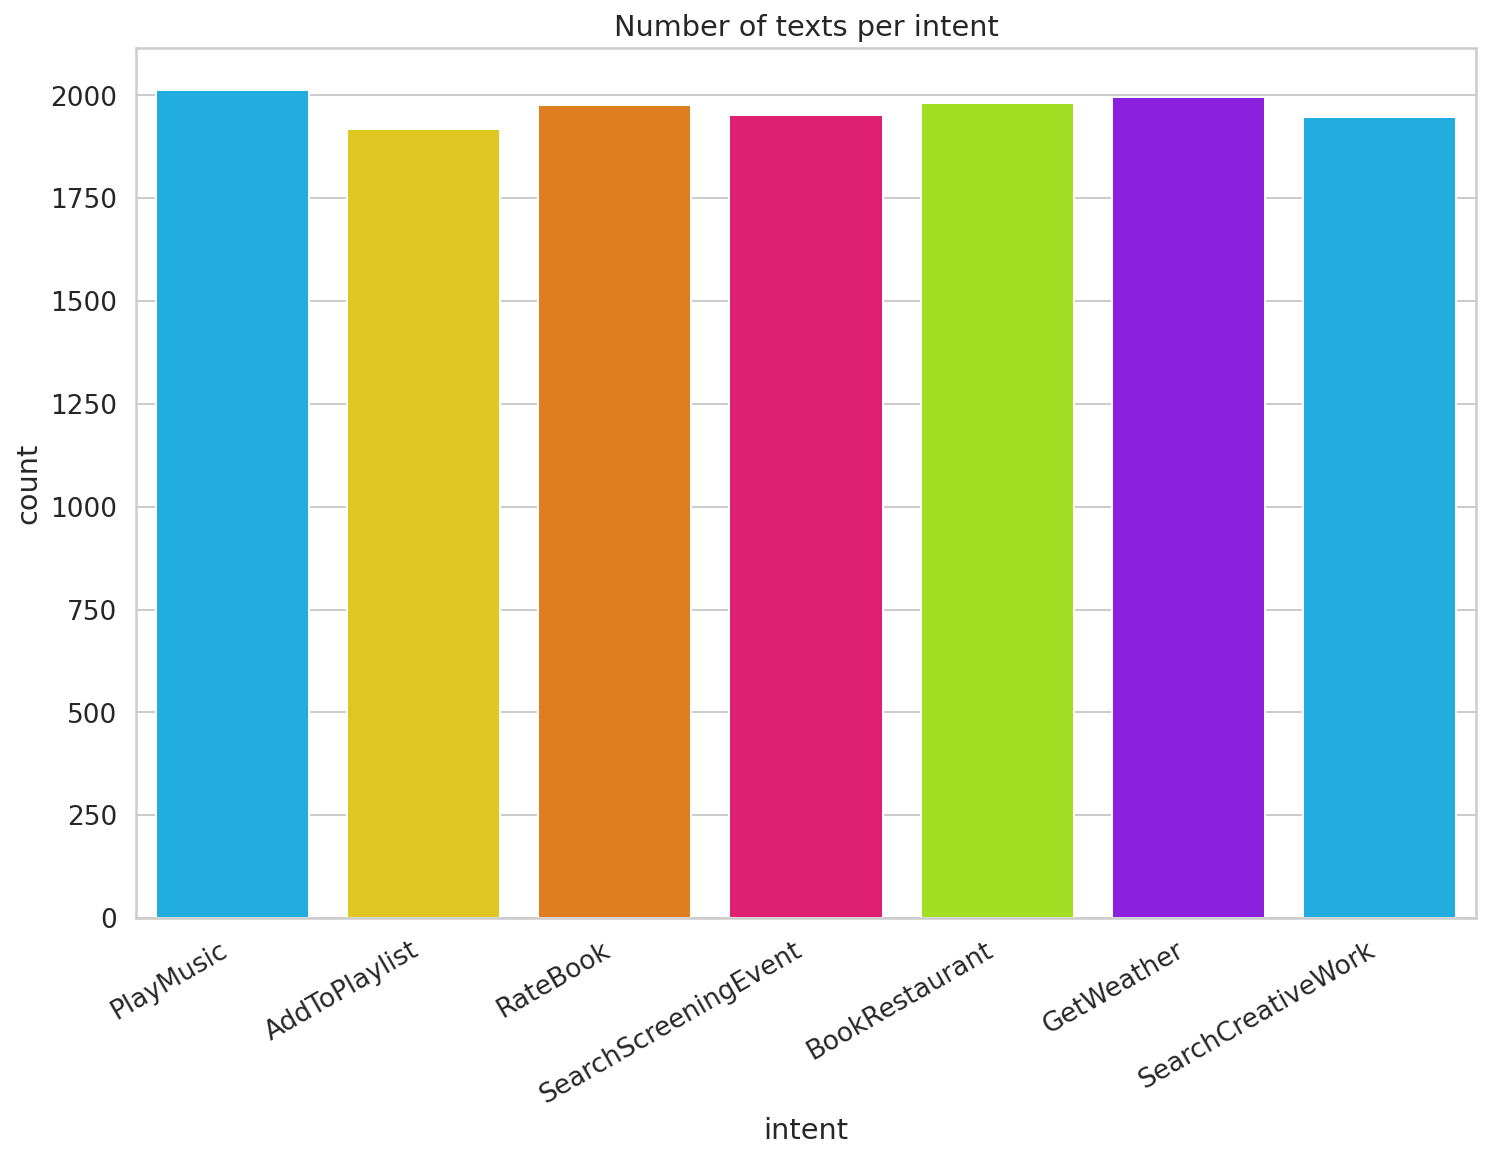

In [18]:
# Visulising the data
chart = sns.countplot(train.intent, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

# Intent Recognition


---




### Downloading pretrained BERT model

In [19]:
# Download the Pre trained BERT Model
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2020-08-23 06:40:20--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.195.128, 74.125.124.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   154MB/s    in 2.5s    

2020-08-23 06:40:22 (154 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [20]:
# Unziping the model zip file
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [21]:
# Making 'model' folder
os.makedirs("model", exist_ok=True)

In [22]:
# Move all the files of model into 'model' folder
!mv uncased_L-12_H-768_A-12/ model

In [23]:
# Accessing the files of model
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

In [24]:
print(bert_ckpt_dir)
print(bert_ckpt_file)
print(bert_config_file)

model/uncased_L-12_H-768_A-12
model/uncased_L-12_H-768_A-12/bert_model.ckpt
model/uncased_L-12_H-768_A-12/bert_config.json


## Data Preprocesing

Converting to tokens and then tokenids

In [25]:
class IntentDetectionData:
  DATA_COLUMN = "text"
  LABEL_COLUMN = "intent"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    train, test = map(lambda df: df.reindex(df[IntentDetectionData.DATA_COLUMN].str.len().sort_values().index), [train, test])
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [26]:
# Tokenization of vacablery
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [27]:
tokenizer.vocab.keys()

odict_keys(['[PAD]', '[unused0]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', '[unused11]', '[unused12]', '[unused13]', '[unused14]', '[unused15]', '[unused16]', '[unused17]', '[unused18]', '[unused19]', '[unused20]', '[unused21]', '[unused22]', '[unused23]', '[unused24]', '[unused25]', '[unused26]', '[unused27]', '[unused28]', '[unused29]', '[unused30]', '[unused31]', '[unused32]', '[unused33]', '[unused34]', '[unused35]', '[unused36]', '[unused37]', '[unused38]', '[unused39]', '[unused40]', '[unused41]', '[unused42]', '[unused43]', '[unused44]', '[unused45]', '[unused46]', '[unused47]', '[unused48]', '[unused49]', '[unused50]', '[unused51]', '[unused52]', '[unused53]', '[unused54]', '[unused55]', '[unused56]', '[unused57]', '[unused58]', '[unused59]', '[unused60]', '[unused61]', '[unused62]', '[unused63]', '[unused64]', '[unused65]', '[unused66]', '[unused67]', '[unused68]', '[unused69]', '[unused7

## Creating Model

Use BERT pretrained model and fine tune it for our problem by adding some layers.

In [28]:
def Create_Modle(max_seq_len, bert_ckpt_file):
  with tf.io.gfile.GFile(bert_config_file,'r') as reader:
    bc = StockBertConfig.from_json_string(reader.read())
    bert_params = map_stock_config_to_params(bc)
    bert_params.adapter_size = None
    # Creating Model
    bert = BertModelLayer.from_params(bert_params, name='bert')
  # Keras Input Layer
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name='input_ids')
  bert_output = bert(input_ids)
  # pirnting bert shape
  print('Bert Shape: ', bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:,0,:])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)

  logits = keras.layers.Dense(units=768, activation='tanh')(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation='softmax')(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape = (None, max_seq_len))
  load_stock_weights(bert, bert_ckpt_file) # loading weights

  return model # returning model

## Traing Model

In [29]:
classes = train.intent.unique().tolist()
data = IntentDetectionData(train, test, tokenizer, classes, max_seq_len=128)

13784it [00:04, 3249.36it/s]
700it [00:00, 3220.20it/s]


max seq_len 38


In [30]:
data.train_x.shape

(13784, 38)

In [31]:
data.test_x.shape

(700, 38)

In [32]:
model = Create_Modle(data.max_seq_len, bert_ckpt_file)

Bert Shape:  (None, 38, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f023e273080> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [33]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 38)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 38, 768)           108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 5383  

## Compiling Model

In [34]:
model.compile(
    optimizer = keras.optimizers.Adam(1e-5),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    # matrics = [keras.metrics.SparseCategoricalAccuracy(name='acc')]
)

## Fitting Model

In [35]:
%load_ext tensorboard

In [36]:
# loging
log_dir = 'log/intent_detection/'+datetime.datetime.now().strftime('%Y%m%d-%H%M%s')
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
    x = data.train_x,
    y = data.train_y,
    validation_split = 0.1,
    batch_size = 16,
    shuffle = True,
    epochs = 4
)

Epoch 1/4
776/776 [==============================] - 964s 1s/step - loss: 1.5087 - val_loss: 1.1724
Epoch 2/4
776/776 [==============================] - 948s 1s/step - loss: 1.1846 - val_loss: 1.1705
Epoch 3/4
776/776 [==============================] - 952s 1s/step - loss: 1.1782 - val_loss: 1.1701
Epoch 4/4
776/776 [==============================] - 949s 1s/step - loss: 1.1750 - val_loss: 1.1705


In [37]:
# evaluate the model
scores = model.evaluate(data.test_x, data.test_y, verbose=0)
print(scores)

1.1865242719650269


## Saving Model 

In [38]:
model.save('./Intent_Trained_Bert-Model.h5')  # creates a HDF5 file 'my_model.h5'

## Evaluating Model

In [39]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print('Training Accuracy: ',train_acc)
print('Testing Accuracy: ',test_acc)

431/431 [==============================] - 274s 637ms/step - loss: 1.1725


TypeError: ignored

# Prediting

In [46]:
# predictions by model over test_x data
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [47]:
# printing precision, recall, f1-score, support
print(classification_report(data.test_y,y_pred, target_names=classes))


                      precision    recall  f1-score   support

           PlayMusic       0.99      0.98      0.98        86
       AddToPlaylist       1.00      1.00      1.00       124
            RateBook       1.00      1.00      1.00        80
SearchScreeningEvent       0.98      0.92      0.95       107
      BookRestaurant       0.99      1.00      0.99        92
          GetWeather       1.00      0.99      1.00       104
  SearchCreativeWork       0.90      0.97      0.94       107

            accuracy                           0.98       700
           macro avg       0.98      0.98      0.98       700
        weighted avg       0.98      0.98      0.98       700



In [48]:
# Confusion Matrix
cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes) # converting to panda dataframe

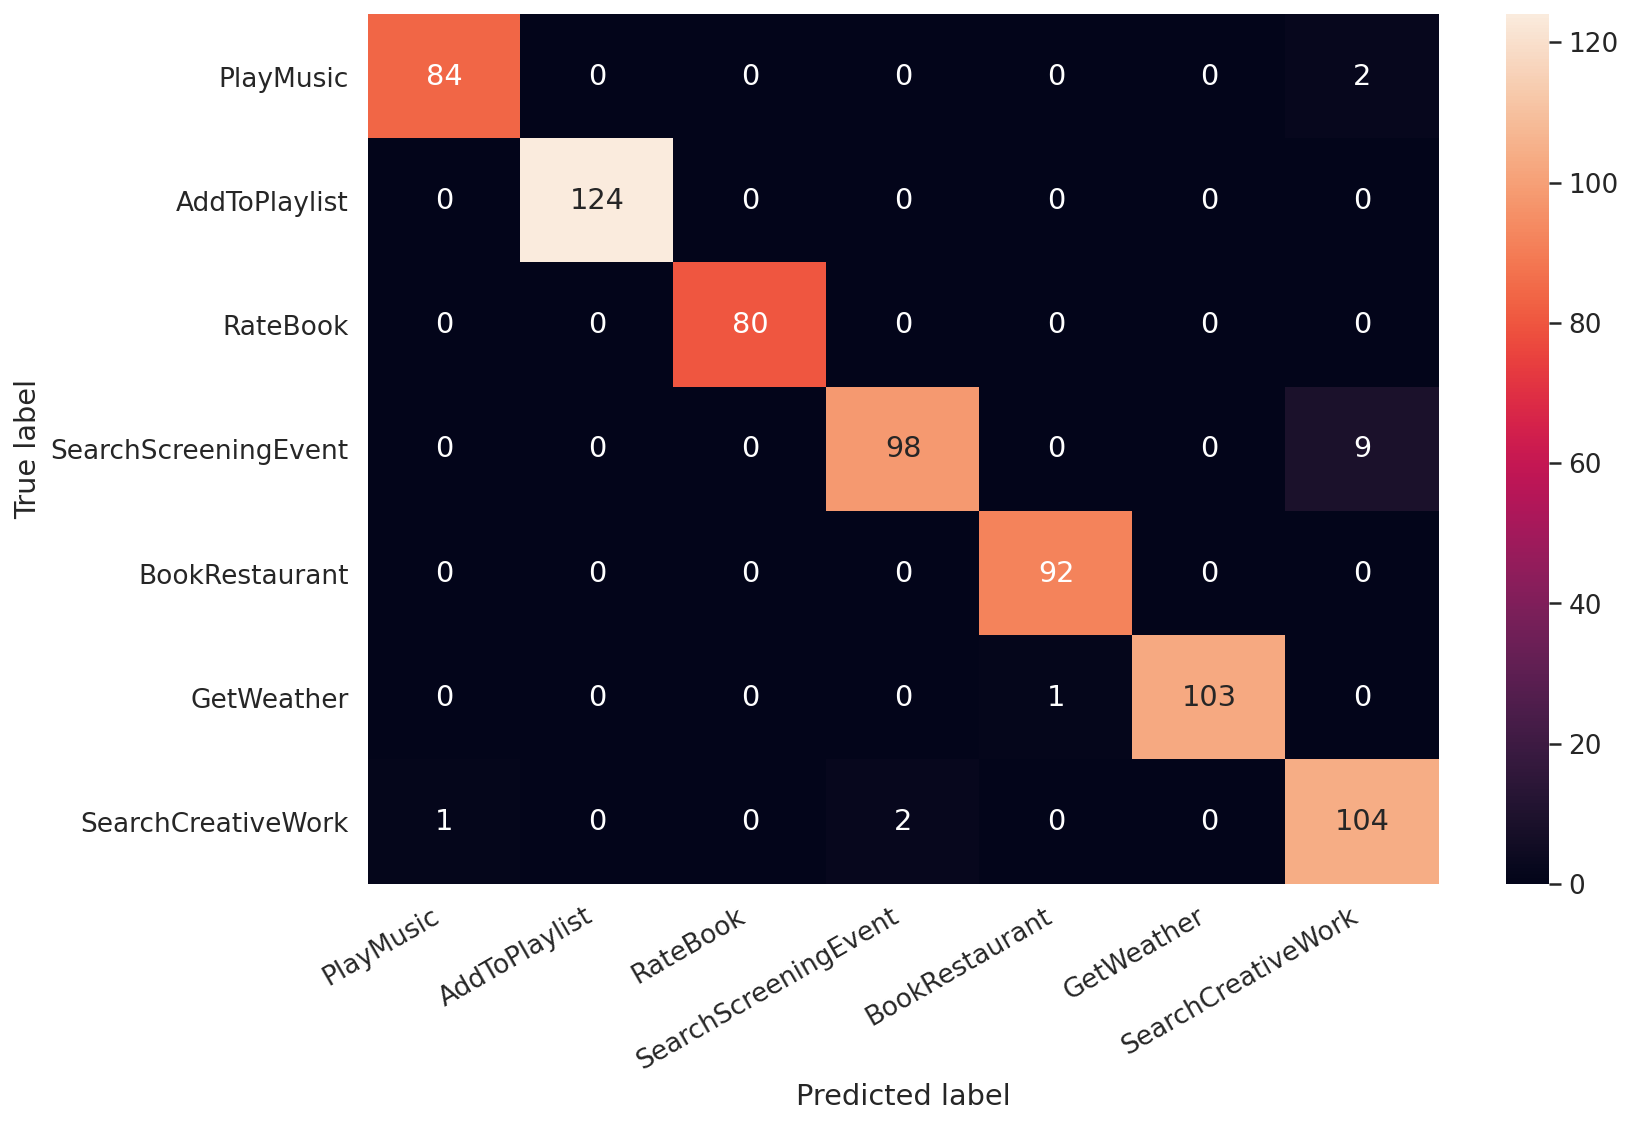

In [52]:
hmap = sns.heatmap(df_cm, annot=True, fmt='d')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [75]:
def prepare_Sentence(sentences):
  # preproceing on these sentences
  pred_tokens = map(tokenizer.tokenize, sentences) # tokenization
  pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens) # appending sperator
  pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens)) # converting tokens to their ids

  pred_token_ids = map(lambda tids: tids+[0]*(data.max_seq_len - len(tids)),  pred_token_ids)
  pred_token_ids = np.array(list(pred_token_ids))
  return pred_token_ids

In [64]:
# Predicting Sentences
def predict_Sentence(sentence):
  pred_token_ids = prepare_Sentence(sentence)
  predictions = model.predict(pred_token_ids).argmax(axis = -1)
  for text, label in zip(sentence, predictions):
    print('Intent:', classes[label])
    print()

In [58]:
for cls in data.classes:
  print('> ',cls)

>  PlayMusic
>  AddToPlaylist
>  RateBook
>  SearchScreeningEvent
>  BookRestaurant
>  GetWeather
>  SearchCreativeWork


In [73]:
text = input('Enter Text: ')
predict_Sentence([text])

Enter Text: you wanna get starbucks cause i am going outside for walk 
Intent: BookRestaurant



In [74]:
text = input('Enter Text: ')
predict_Sentence([text])

Enter Text: apart from other thing i really like that record which was played during the dinner at restaurent
Intent: PlayMusic



In [76]:
text = input('Enter Text: ')
predict_Sentence([text])

Enter Text: Is it windy in Punjab, MA right now?
Intent: GetWeather

